In [15]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import cv2
from sklearn.model_selection import train_test_split
import pickle
import os
import pandas as pd
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import h5py

In [16]:
path = "FaceShape Dataset"
labelFile = 'FaceLabels.csv'
batch_size_val = 50
steps_per_epoch_val = 1000
epochs_val = 30
imageDimesions = (32, 32, 3)
testRatio = 0.2
validationRatio = 0.2

In [17]:
import os
import cv2
import numpy as np

path = "FaceShape Dataset/training_set"
count = 0
images = []
classNo = []
myList = os.listdir(path)
print("Total Classes Detected:", len(myList))

# Filter out non-directory entries
myList = [className for className in myList if os.path.isdir(os.path.join(path, className))]

noOfClasses = len(myList)
print("Importing Classes.....")

for className in myList:
    myPicList = os.listdir(os.path.join(path, className))
    for picName in myPicList:
        try:
            curImg = cv2.imread(os.path.join(path, className, picName))

            if curImg is None:
                print(f"Error loading image: {os.path.join(path, className, picName)}")
                continue

            dim = (32, 32)
            resized = cv2.resize(curImg, dim, interpolation=cv2.INTER_AREA)

            images.append(resized)
            classNo.append(count)

        except Exception as e:
            print(f"Error processing image {os.path.join(path, className, picName)}: {str(e)}")
    print(count, end=" ")
    count += 1

print(" ")
images = np.array(images)
classNo = np.array(classNo)


Total Classes Detected: 6
Importing Classes.....
0 Error loading image: FaceShape Dataset/training_set\Oblong\oblong (724).jpg
1 2 3 4  


In [18]:
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)

In [19]:
print("Data Shapes")
print("Train", end="");
print(X_train.shape, y_train.shape)
print("Validation", end="");
print(X_validation.shape, y_validation.shape)
print("Test", end="");
print(X_test.shape, y_test.shape)

Data Shapes
Train(2559, 32, 32, 3) (2559,)
Validation(640, 32, 32, 3) (640,)
Test(800, 32, 32, 3) (800,)


In [20]:
data = pd.read_csv(labelFile)
print("data shape ", data.shape, type(data))

data shape  (5, 2) <class 'pandas.core.frame.DataFrame'>


[503, 520, 503, 530, 503]


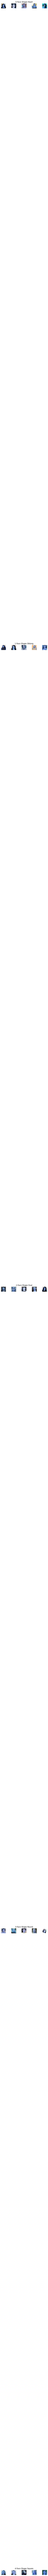

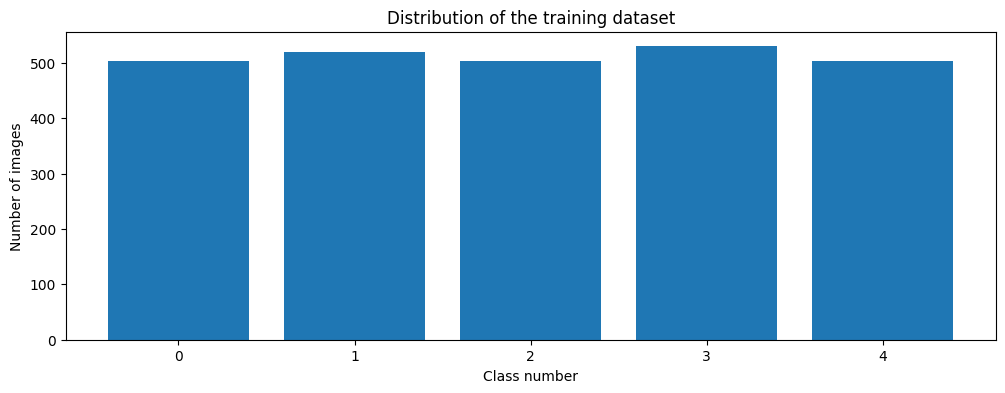

In [21]:
num_of_samples = []
cols = 5
num_classes = noOfClasses
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 300))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected) - 1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row["Name"])
            num_of_samples.append(len(x_selected))

print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [22]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img


def equalize(img):
    img = cv2.equalizeHist(img)
    return img


def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img / 255
    return img

In [23]:
X_train = np.array(list(map(preprocessing, X_train)))
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))
cv2.imshow("GrayScale Images",
           X_train[random.randint(0, len(X_train) - 1)])

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

dataGen = ImageDataGenerator(width_shift_range=0.1,
                             # 0.1 = 10%     IF MORE THAN 1 E.G 10 THEN IT REFFERS TO NO. OF  PIXELS EG 10 PIXELS
                             height_shift_range=0.1,
                             zoom_range=0.2,  # 0.2 MEANS CAN GO FROM 0.8 TO 1.2
                             shear_range=0.1,  # MAGNITUDE OF SHEAR ANGLE
                             rotation_range=10)  # DEGREES
dataGen.fit(X_train)
batches = dataGen.flow(X_train, y_train,
                       batch_size=20)
X_batch, y_batch = next(batches)

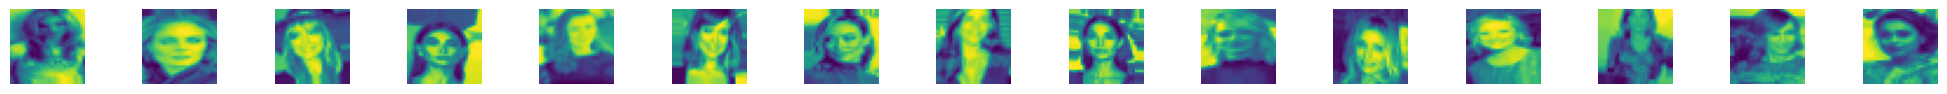

In [24]:
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(imageDimesions[0], imageDimesions[1]))
    axs[i].axis('off')
plt.show()

y_train = to_categorical(y_train, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)

In [25]:
def myModel():
    no_Of_Filters = 60
    size_of_Filter = (5, 5)

    size_of_Filter2 = (3, 3)
    size_of_pool = (2, 2)
    no_Of_Nodes = 500
    model = Sequential()
    model.add((Conv2D(no_Of_Filters, size_of_Filter, input_shape=(imageDimesions[0], imageDimesions[1], 1),
                      activation='relu')))
    model.add((Conv2D(no_Of_Filters, size_of_Filter, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))

    model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu')))
    model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(no_Of_Nodes, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses, activation='softmax'))

    model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [26]:
model = myModel()
history = model.fit(X_train, y_train, epochs=epochs_val, steps_per_epoch=steps_per_epoch_val, batch_size=batch_size_val,
                    validation_data=(X_validation, y_validation), shuffle=1)

c:\Users\babby\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


ValueError: Argument(s) not recognized: {'lr': 0.001}